In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

import joblib 

In [2]:
df_s = pd.read_csv('/Users/mstee/Documents/School/projectwork/data/smhi_temp_data_save.csv', usecols=[0, 1, 2, 3], header=6, sep=';')
df_g = pd.read_csv('/Users/mstee/Documents/School/projectwork/data/avg_daily_temp_curated.csv')

In [3]:
df_s
# df_g

,Datum,Tid (UTC),Lufttemperatur,Kvalitet
0,1944-01-01,07:00:00,1.6,G
1,1944-01-01,13:00:00,3.8,G
2,1944-01-01,18:00:00,4.2,G
3,1944-01-02,07:00:00,0.6,G
4,1944-01-02,13:00:00,3.8,G
...,...,...,...,...
435387,2006-12-05,09:00:00,9.4,G
435388,2006-12-05,10:00:00,10.1,Y
435389,2006-12-05,11:00:00,10.8,Y
435390,2006-12-05,12:00:00,10.9,G


Change to monthly temp 

In [4]:
# Assuming your DataFrame is called df_s
# Convert the "Datum" column to a datetime object
df_s['Datum'] = pd.to_datetime(df_s['Datum'])

# Group the data by date and calculate the daily mean temperature
df_s = df_s.groupby('Datum')['Lufttemperatur'].mean().reset_index()

# # Rename the columns in the new DataFrame
df_s = df_s.rename(columns={'Datum': 'Datum', 'Lufttemperatur': 'Snittemperatur'})

# # Print the resulting DataFrame
# print(daily_temp)
df_s

,Datum,Snittemperatur
0,1944-01-01,3.200000
1,1944-01-02,3.600000
2,1944-01-03,2.800000
3,1944-01-04,-4.466667
4,1944-01-05,-1.400000
...,...,...
22980,2006-12-01,8.033333
22981,2006-12-02,8.808333
22982,2006-12-03,8.112500
22983,2006-12-04,8.566667


Change variable types 

In [5]:
print(df_s.dtypes)

Datum             datetime64[ns]
Snittemperatur           float64
dtype: object


EDA 

In [6]:
print(df_s['Snittemperatur'].describe())

count    22985.000000
mean         7.481754
std          7.437469
min        -21.704167
25%          1.973913
50%          7.437500
75%         13.779167
max         28.600000
Name: Snittemperatur, dtype: float64


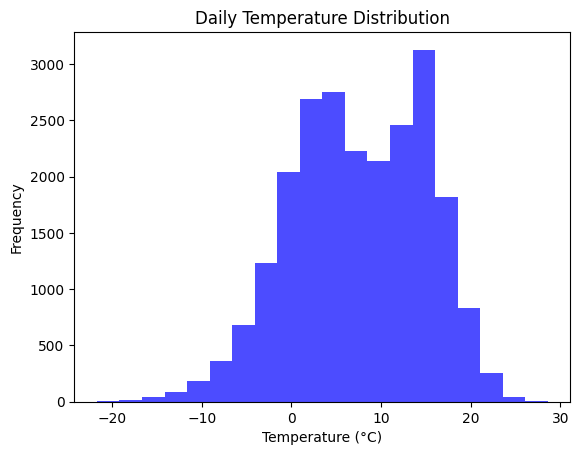

In [7]:


temperature_data = df_s['Snittemperatur']

# Create a histogram
plt.hist(temperature_data, bins=20, color='blue', alpha=0.7)
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Daily Temperature Distribution')

plt.show()

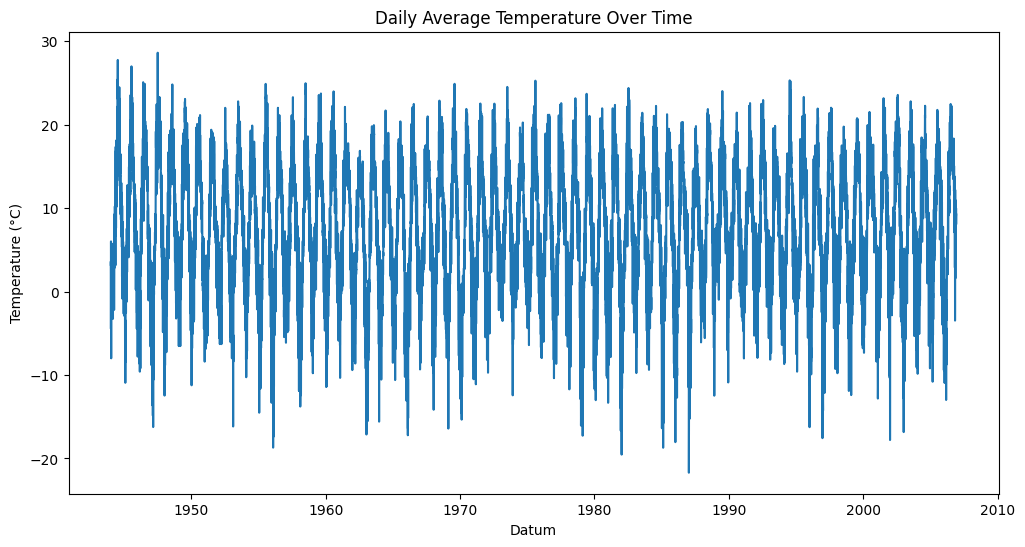

In [8]:

plt.figure(figsize=(12, 6))
plt.plot(df_s['Datum'], df_s['Snittemperatur'])
plt.xlabel('Datum')
plt.ylabel('Temperature (°C)')
plt.title('Daily Average Temperature Over Time')
plt.show()

attempt to insert in gotheburg in the missing save data, dates after 2006-12-06

In [9]:
noentries_subset = df_s[(df_s['Datum'] >= '2006-12-06') & (df_s['Datum'] <= '2008-12-31')]

len(noentries_subset)
noentries_subset

,Datum,Snittemperatur


In [10]:
columns_to_drop = ['Month', 'Kvalitet']
df_g = df_g.drop(columns=columns_to_drop)

In [11]:


# Make sure the "Datum" column in both dataframes is of datetime type
df_s['Datum'] = pd.to_datetime(df_s['Datum'])
df_g['Datum'] = pd.to_datetime(df_g['Datum'])

# Filter the rows from df_sav that match your date criteria
filtered_df_g = df_g[(df_g['Datum'] >= '2006-12-06')]
# filtered_df_sav_2 = df_sav[]
# Now, you can concatenate the filtered_df_g with df_s
df_s = pd.concat([df_s, filtered_df_g], ignore_index=True)

# Sort the resulting dataframe by the "Datum" column
df_s = df_s.sort_values(by='Datum')

# Reset the index
df_s = df_s.reset_index(drop=True)


In [12]:
df_s

,Datum,Snittemperatur
0,1944-01-01,3.200000
1,1944-01-02,3.600000
2,1944-01-03,2.800000
3,1944-01-04,-4.466667
4,1944-01-05,-1.400000
...,...,...
29002,2023-06-27,18.180000
29003,2023-06-28,19.720000
29004,2023-06-29,19.220000
29005,2023-06-30,17.400000


In [13]:
df_s['Year'] = df_s['Datum'].dt.year

In [14]:
df_s

,Datum,Snittemperatur,Year
0,1944-01-01,3.200000,1944
1,1944-01-02,3.600000,1944
2,1944-01-03,2.800000,1944
3,1944-01-04,-4.466667,1944
4,1944-01-05,-1.400000,1944
...,...,...,...
29002,2023-06-27,18.180000,2023
29003,2023-06-28,19.720000,2023
29004,2023-06-29,19.220000,2023
29005,2023-06-30,17.400000,2023


In [15]:
df_s['Year'].value_counts().sort_values(ascending=False)

Year
1944    366
1980    366
1960    366
1948    366
1952    366
       ... 
1946    365
2021    365
2022    365
2013    335
2023    182
Name: count, Length: 80, dtype: int64

Time series analysis 

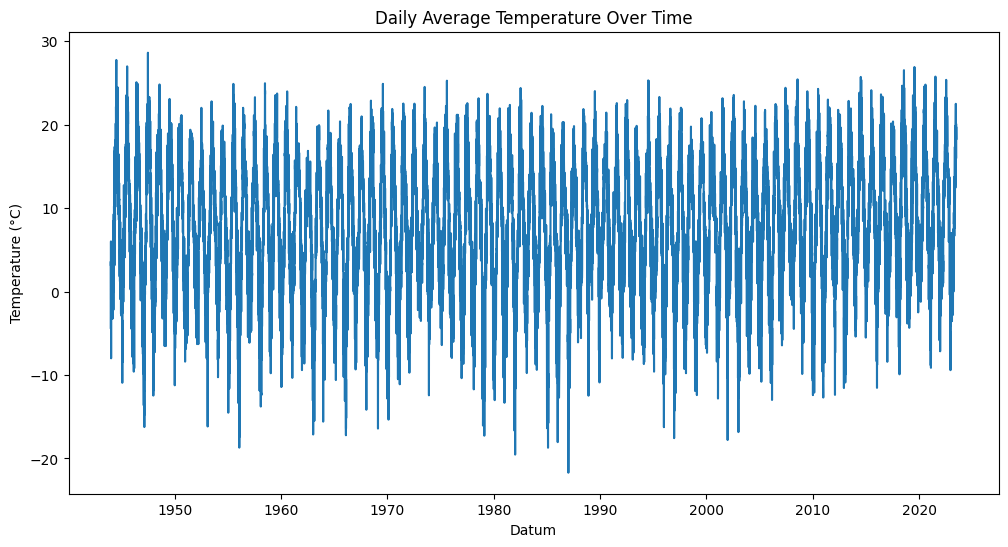

In [16]:

plt.figure(figsize=(12, 6))
plt.plot(df_s['Datum'], df_s['Snittemperatur'])
plt.xlabel('Datum')
plt.ylabel('Temperature (°C)')
plt.title('Daily Average Temperature Over Time')
plt.show()

# sklearn , linear regression 

prep data 

In [17]:
# set datum as index , drop year column 
df_s = df_s.set_index('Datum')
df_s = df_s.drop("Year", axis = 1)

df_s


,Snittemperatur
Datum,
1944-01-01,3.200000
1944-01-02,3.600000
1944-01-03,2.800000
1944-01-04,-4.466667
1944-01-05,-1.400000
...,...
2023-06-27,18.180000
2023-06-28,19.720000
2023-06-29,19.220000


In [18]:
# set frequency to to daily data 
df_s = df_s.asfreq('D')
df_s = df_s.sort_index()


In [19]:
# check for missing values, as time series won't work with missing values
print(f'Number of rows with missing values: {df_s.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0010331645831180907


In [20]:
# temporarily fill the gaps with the mean temp for the entire data set, until mean values for that month are inserted in. 
snitt_temp = df_s['Snittemperatur'].mean()
df_s['Snittemperatur'] = df_s['Snittemperatur'].fillna(snitt_temp)

In [21]:
print(f'Number of rows with missing values: {df_s.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


Train dates : 1944-01-01 00:00:00 --- 2009-12-31 00:00:00  (n=24107)
Test dates  : 2010-01-01 00:00:00 --- 2023-07-01 00:00:00  (n=4930)


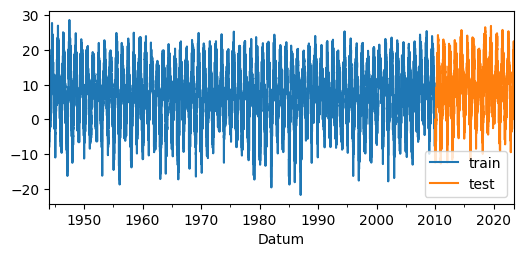

In [22]:
# split training and test data, with cut off at year, 2010

cutoff_date = '2010-01-01'
data_train = df_s[df_s.index < cutoff_date]
data_test = df_s[df_s.index >= cutoff_date]


print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Snittemperatur'].plot(ax=ax, label='train')
data_test['Snittemperatur'].plot(ax=ax, label='test')
ax.legend()
plt.show()




In [233]:
data_train.dtypes

Snittemperatur    float64
dtype: object

recursive autoregressive forecasting 

In [38]:
forecaster = ForecasterAutoreg(
    regressor =RandomForestRegressor(random_state=42), 
    lags = 14
)

forecaster.fit(y = data_train['Snittemperatur'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: None 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1944-01-01 00:00:00'), Timestamp('2009-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-17 21:00:15 
Last fit date: 2023-10-17 21:00:40 
Skforecast versi

Predictions 

In [39]:

predictions = forecaster.predict(steps = 4930)
predictions

2010-01-01   -8.539528
2010-01-02   -6.248436
2010-01-03   -4.926296
2010-01-04   -4.967514
2010-01-05   -4.548608
                ...   
2023-06-27   -0.565804
2023-06-28   -0.132592
2023-06-29   -0.185165
2023-06-30   -0.063018
2023-07-01    0.068060
Freq: D, Name: pred, Length: 4930, dtype: float64

In [34]:
data_test

,Snittemperatur
Datum,
2010-01-01,-6.70
2010-01-02,-8.00
2010-01-03,-8.46
2010-01-04,-1.49
2010-01-05,-7.74
...,...
2023-06-27,18.18
2023-06-28,19.72
2023-06-29,19.22


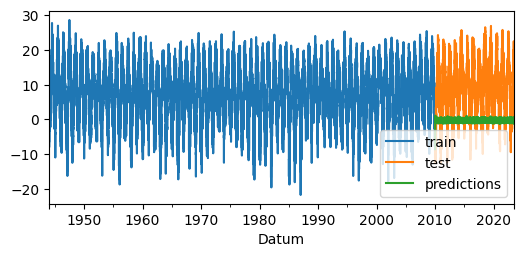

In [40]:
fig, ax = plt.subplots(figsize = (6 , 2.5))
data_train['Snittemperatur'].plot(ax=ax, label = 'train')
data_test['Snittemperatur'].plot(ax=ax, label = 'test')
predictions.plot(ax=ax, label= 'predictions')
ax.legend()

In [42]:
# test_ error 

error_mse = mean_squared_error(
    y_true =  data_test['Snittemperatur'],
    y_pred = predictions
)

rmse = np.sqrt(error_mse)
print(f'Test error (mse) : {rmse}')

Test error (mse) : 11.88870063577203


the model is usually off by 11.8°C  nice! 

Grid search 

In [44]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state = 42), 
    lags = 14 
)

#lags used as predictors 

lags_grid = [14, 30]

#Regressor's hyperparameters 
param_grid = {'n_estimators': [100,500], 
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
     forecaster         = forecaster,
                        y = data_train['Snittemperatur'],
                        param_grid = param_grid,
                        lags_grid = lags_grid,
                        steps = 14,
                        refit= False,
                        metric = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size = False,
                        return_best = True,
                        n_jobs = 'auto',
                        verbose = False
)

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 13.214928957934283



In [47]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",13.214929,10,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 500}",13.231681,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 100}",13.239887,10,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",13.315131,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 100}",13.957347,5,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 500}",13.996541,5,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",14.057029,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",14.097810,5,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 3, 'n_estimators': 100}",15.387208,3,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",15.445874,3,100


In [48]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 30
             )

forecaster.fit(y=data_train['Snittemperatur'])

In [55]:
# save forecaster 

joblib.dump(forecaster, 'forecaster_model.pkl')

['forecaster_model.pkl']

In [49]:
#Predictions 
predictions = forecaster.predict(steps= 4930)

In [52]:
predictions

2010-01-01   -8.914712
2010-01-02   -7.345444
2010-01-03   -5.665994
2010-01-04   -4.891603
2010-01-05   -3.988410
                ...   
2023-06-27   -2.255502
2023-06-28   -2.251885
2023-06-29   -2.251885
2023-06-30   -2.255502
2023-07-01   -2.255502
Freq: D, Name: pred, Length: 4930, dtype: float64

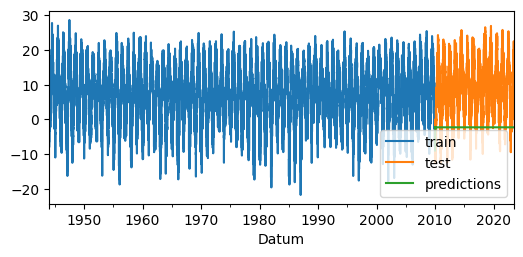

In [53]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Snittemperatur'].plot(ax=ax, label='train')
data_test['Snittemperatur'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [51]:
# test_ error 

error_mse = mean_squared_error(
    y_true =  data_test['Snittemperatur'],
    y_pred = predictions
)

rmse = np.sqrt(error_mse)
print(f'Test error (rmse) : {rmse}')

Test error (mse) : 13.592283028499367


# Seasonal decomposition with statmodels

In [26]:
decomposition = seasonal_decompose(df_s['Snittemperatur'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal   
residual = decomposition.resid

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [38]:
# export the filled out save data set with just temp

df_s.to_csv('/Users/mstee/Documents/School/projectwork/data/Mike1310_save_averagetemp_with_GBGdata.csv', index = False)

Neural Networks? LSTM? 